In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/My\ paper

/content/drive/Shareddrives/My paper


In [ ]:
import math
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

In [ ]:
# Import the Keras libraries and packages
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed, Embedding, Input
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras import backend as K

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn import tree
from scipy.stats import spearmanr

In [ ]:
event_data = pd.read_csv('./Customer Value Prediction/TABLES/Event Sequence.csv')

In [ ]:
feature_data = pd.read_csv('./Customer Value Prediction/TABLES/Handcrafted Features.csv')

In [ ]:
event_data.columns

Index(['MemberID', 'TotalSalesAmount', 'Active', 'VIP', 'bh', 'TimeDiff'], dtype='object')

In [ ]:
feature_data.columns

Index(['MemberID', 'Age', 'Lifespan', 'Lifespan_days', 'Recency', 'Frequency',
       'Monetary', 'Monetary_total', 'CAI', 'ActiveDays', 'CompleteOrders',
       'ReturnOrders', 'PromotionUsed', 'PromotionUsedRate', 'FinishedOrders',
       'ReturnRate', 'PurchaseRatio', 'TotalSalesAmount', 'Active', 'VIP'],
      dtype='object')

In [ ]:
print(len(event_data), len(feature_data))

3449784 83931


## 處理 Event Sequence -> 每個會員的資料合成一個 row

In [ ]:
event_data['bh_codes'] = pd.Categorical(event_data.bh).codes
event_data['bh_codes'] = event_data['bh_codes'] + 1 # 因為之後會補 0 

In [ ]:
bhs = pd.DataFrame(event_data.groupby('MemberID')['bh'].apply(list))
bh_codes= pd.DataFrame(event_data.groupby('MemberID')['bh_codes'].apply(list))
TimeDiffs = pd.DataFrame(event_data.groupby('MemberID')['TimeDiff'].apply(list))

In [ ]:
event_data_unified = pd.merge(bhs, bh_codes, on='MemberID')
event_data_unified = pd.merge(event_data_unified, TimeDiffs, on='MemberID')

In [ ]:
all_event = np.array(event_data_unified['bh_codes'])

In [ ]:
event_cols = []
PADDING_LENGTH = 60

for i in range(1, PADDING_LENGTH+1):
  event_cols.append('e_'+ str(i))

In [ ]:
pad_events = pd.DataFrame(pad_sequences(all_event, maxlen=PADDING_LENGTH), columns=event_cols)

In [ ]:
pad_events.head()

e_1  e_2  e_3  e_4  e_5  e_6  e_7  e_8  e_9  e_10  ...  e_51  e_52  e_53  \
0    6    6    6    6    6    6    6    6    6    10  ...     9     9     8   
1    6    6   10    6    6    6    6    8    6     6  ...     9    10     1   
2    9    9    8   10    8   10    8   10    8    10  ...     8     9     9   
3    0    0    0    0    0    0    0    0    0     0  ...     0     0     0   
4    8    8    9    9    9    9    8    8    9     9  ...    10     8    10   

   e_54  e_55  e_56  e_57  e_58  e_59  e_60  
0     9     9     8     9     9     8     9  
1     8     9     9    10    10    10     9  
2     9     9     9    10    10    10    10  
3     0     0     0     8     8    10     8  
4     8    10     8    10     8     8     9  

[5 rows x 60 columns]

In [ ]:
len(pad_events)

83931

## 處理 feature data

In [ ]:
# feature columns
uds_cols = ['MemberID', 'Lifespan_days', 'CAI', 'Monetary', 'Recency', 'Frequency', 'ActiveDays', 'PromotionUsedRate', 'CompleteOrders', 'ReturnRate', 'TotalSalesAmount', 'Active', 'VIP']

In [ ]:
feature_data_uds = feature_data[uds_cols]

In [ ]:
feature_data_uds.head()

MemberID  Lifespan_days       CAI  \
0  sq6A9cXpkm6osmubTCLs8bWeANzqL5qGj9eHJszdQSU=           1517  0.138333   
1  5zctnMgeBBnl88Ncab+TgtLtTv4IKqEqHZOVDdMbzp0=           1225  0.090855   
2  CFwUYZ8qzgF+9DlCOT+VyjhQFqB3VoHz/83rwJoodFY=           1414 -0.186684   
3  Sln7tpbmaTY2lN9m/PFIjHMFr8oWt2x5BpTAoQ5wV8I=           1427 -0.059084   
4  MJYoc2LF9yz2q+mJ7IlBbEf/oT5TvTP5s0Tu8t1pNMY=           1520 -0.318323   

   Monetary  Recency  Frequency  ActiveDays  PromotionUsedRate  \
0    840.00      123        2.0        16.0           0.200000   
1   2212.25        8        4.0        50.0           0.923077   
2      0.00     1035        0.0         3.0           0.000000   
3    703.00      271        2.0         2.0           0.333333   
4   1016.00      244        1.0         8.0           0.363636   

   CompleteOrders  ReturnRate  TotalSalesAmount  Active  VIP  
0               5    1.000000               0.0     0.0  0.0  
1              13    0.000000            3635.0     1.0  1.0  
2               3    0.666667               0.0     0.0  0.0  
3               6    0.833333               0.0     0.0  0.0  
4              11    0.363636            4840.0     1.0  1.0

In [ ]:
len(feature_data_uds)

83931

## 合併 feature data 及 event data

In [ ]:
all_data = pd.concat([feature_data_uds, pad_events], axis=1)

In [ ]:
# len(all_data)

In [ ]:
# Counter(all_data['VIP'])

In [ ]:
# X = all_data.drop(['Active'], axis=1)
# y = all_data['Purchase']

# Event based LSTM

In [ ]:
X = pad_events
y = all_data['Active'].astype(int)

In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 62829, 1: 21102})


## 做 undersampling

In [ ]:
class DataUds():
  def __init__(self, minor_weight, X, y):
    self.minor_weight = minor_weight
    self.X = X
    self.y = y

    self.reset()

  def reset(self):
    self.X_res = []
    self.y_res = []

  def get_major_num(self):
    counter = Counter(self.y)
    print('Orginal num:', counter)
    major_num = int(counter[1] * ((1-self.minor_weight)/self.minor_weight))
    return major_num

  def undersample(self, major_num):
    nm = NearMiss(sampling_strategy={0: major_num}, version=1)
    self.X_res, self.y_res = nm.fit_resample(X, y) 
    print('Undersmapling num:', Counter(self.y_res))

  def run(self):
    major_num = self.get_major_num()
    self.undersample(major_num)

In [ ]:
uds_1 = DataUds(0.5, X, y)
uds_1.run()

Orginal num: Counter({0: 62829, 1: 21102})
Undersmapling num: Counter({0: 21102, 1: 21102})


In [ ]:
X_res = uds_1.X_res
y_res = uds_1.y_res

In [ ]:
len(X_res)

42204

In [ ]:
event_X_uds = np.array(X_res[event_cols]).reshape(len(X_res), PADDING_LENGTH, 1)
event_y_uds = y_res

In [ ]:
event_data_uds = pd.concat([X_res, y_res], axis=1)

In [ ]:
event_data_uds.to_csv('Event Sequence + RF Undersampled Data.csv', index=False)

## 切割訓練測試集

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(event_X_uds, event_y_uds, test_size=0.2, random_state=123)

In [ ]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

33763 33763 8441 8441


In [ ]:
X_train.shape

(33763, 60, 1)

In [ ]:
y_train.shape

(33763,)

In [ ]:
Counter(y_train)

Counter({0: 16950, 1: 16813})

In [ ]:
Counter(y_test)

Counter({0: 4152, 1: 4289})

In [ ]:
event_data_uds['Train/Test'] = ['Test'] * len(event_data_uds)
event_data_uds.loc[y_train.index, 'Train/Test'] = 'Train'

In [ ]:
event_data_uds.to_csv('Train Test Data.csv', index=False)

## LSTM

## model 試驗

In [ ]:
model = Sequential()
  
model.add(Embedding(input_dim=11, output_dim=8))
model.add(LSTM(64, input_shape=(PADDING_LENGTH, 8), return_sequences=True))        
model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 8)           88        
                                                                 
 lstm_11 (LSTM)              (None, None, 64)          18688     
                                                                 
 dense_11 (Dense)            (None, None, 1)           65        
                                                                 
Total params: 18,841
Trainable params: 18,841
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)
EPOCHS = 20
BATCH_SIZE = 512
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[callback], verbose=1)

Epoch 1/20
53/53 [==============================] - 15s 241ms/step - loss: 0.5869 - accuracy: 0.6964 - val_loss: 0.5535 - val_accuracy: 0.7162
Epoch 2/20
53/53 [==============================] - 12s 230ms/step - loss: 0.5419 - accuracy: 0.7216 - val_loss: 0.5411 - val_accuracy: 0.7295
Epoch 3/20
53/53 [==============================] - 12s 231ms/step - loss: 0.5370 - accuracy: 0.7249 - val_loss: 0.5419 - val_accuracy: 0.7253
Epoch 4/20
53/53 [==============================] - 13s 242ms/step - loss: 0.5308 - accuracy: 0.7269 - val_loss: 0.5279 - val_accuracy: 0.7347
Epoch 5/20
53/53 [==============================] - 12s 229ms/step - loss: 0.5285 - accuracy: 0.7284 - val_loss: 0.5248 - val_accuracy: 0.7360
Epoch 6/20
53/53 [==============================] - 12s 230ms/step - loss: 0.5249 - accuracy: 0.7309 - val_loss: 0.5280 - val_accuracy: 0.7310
Epoch 7/20
53/53 [==============================] - 12s 229ms/step - loss: 0.5207 - accuracy: 0.7330 - val_loss: 0.5183 - val_accuracy: 0.7394

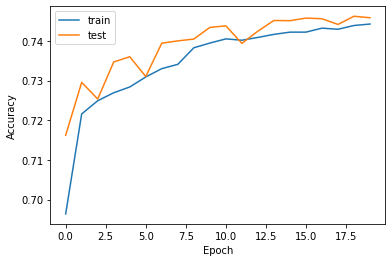

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1 score: ', f1_score(y_pred, y_test))
print('AUC score: ', roc_auc_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.8003791020021325
F1 score:  0.772389571795218
AUC score:  0.8248339881933494
Confusion matrix:


array([[3897,  255],
       [1430, 2859]])

In [ ]:
labels = ['Inactive', 'Active']

In [ ]:
Counter(y_test)

Counter({0: 4152, 1: 4289})

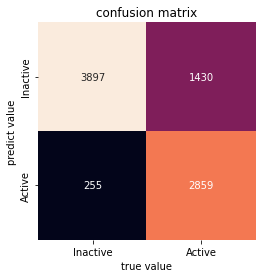

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred, y_test,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

    Inactive       0.94      0.73      0.82      5327
      Active       0.67      0.92      0.77      3114

    accuracy                           0.80      8441
   macro avg       0.80      0.82      0.80      8441
weighted avg       0.84      0.80      0.80      8441



In [ ]:
X_all = np.rot90(np.array(X).reshape(len(X), 1, PADDING_LENGTH), 3, (1, 2))
prediction_all = model.predict(X_all)

In [ ]:
y_pred_all = (prediction_all[:, -1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred_all, y))
print('F1 score: ', f1_score(y_pred_all, y))
print('AUC score: ', roc_auc_score(y_pred_all, y))
print('Confusion matrix:')
confusion_matrix(y_pred_all, y)

Accuracy of the model :  0.42111972930145
F1 score:  0.36430720921104276
AUC score:  0.5003020214029893
Confusion matrix:


array([[21423,  7180],
       [41406, 13922]])

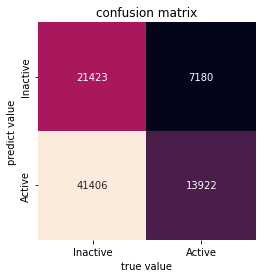

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

    Inactive       0.34      0.75      0.47     28603
      Active       0.66      0.25      0.36     55328

    accuracy                           0.42     83931
   macro avg       0.50      0.50      0.42     83931
weighted avg       0.55      0.42      0.40     83931



## 取得每次 output

In [ ]:
model.layers[0].get_weights()[0].shape

(11, 8)

In [ ]:
def get_layer_output(X, idx):
  get_output = K.function([model.layers[0].input], [model.layers[idx].output])
  return get_output([X])

In [ ]:
layer_output_1 = get_layer_output(X_test, 0)
layer_output_2 = get_layer_output(X_test, 2)

In [ ]:
ot = pd.DataFrame(layer_output_2[0][:, PADDING_LENGTH-1], columns=['P'])
ot[ot['P']>0.5]

P
3     0.605278
6     0.994957
7     0.999942
8     0.999804
11    0.543378
...        ...
8433  0.998877
8434  0.999284
8436  0.739850
8437  0.513400
8439  0.933295

[3114 rows x 1 columns]

## 結果解釋

In [ ]:
bh_dict = ['None', 'add', 'checkout', 'purchase', 'register', 'search', 'traffic', 'viewactivity', 'viewcategory', 'viewmainpage', 'viewproduct']

In [ ]:
def get_output_df(idx):
  bh_eg = list(X_test[idx].reshape(1,PADDING_LENGTH)[0])
  bh_eg = [i for i in bh_eg if i != 0] # 把 padding 的 event 拿掉
  output_eg = list(layer_output_2[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(bh_eg):]
  bh_name_eg = [bh_dict[x] for x in bh_eg]

  df_eg = pd.DataFrame([idx] * len(bh_eg), columns=['Member'])
  df_eg['bh'] = bh_name_eg
  df_eg['Output'] = output_eg

  return df_eg

In [ ]:
def output_ex(idx):
  eg_1 = list(X_test[idx].reshape(1,PADDING_LENGTH)[0])
  eg_1 = [i for i in eg_1 if i != 0] # 把 padding 的 event 拿掉
  output_1 = list(layer_output_2[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(eg_1):]

  # 開始繪圖
  x_axis = range(len(eg_1))
  base = [0.5] * len(x_axis)
  eg_1_bh = [bh_dict[x] for x in eg_1]

  plt.figure(figsize=(12,6))
  plt.plot(x_axis, output_1, color="red", marker='o', markerfacecolor='black', markersize=4)
  plt.plot(x_axis, base, color="blue", linestyle='dashed')
  plt.xticks(x_axis,eg_1_bh,rotation=90)
  plt.xlabel('Behavior Events')
  plt.ylabel('P(VIP)')
  plt.show()

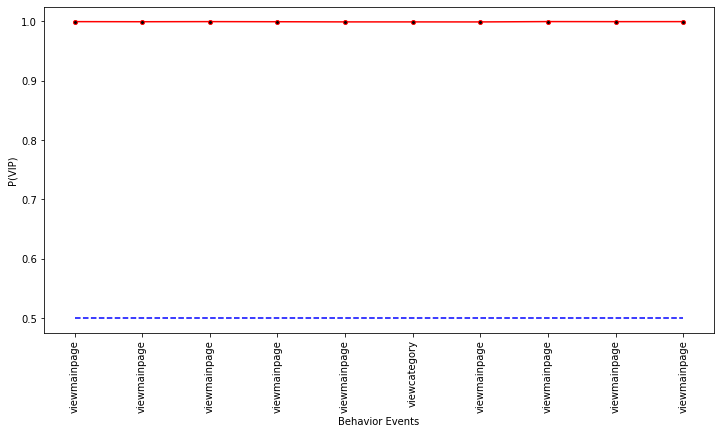

In [ ]:
output_ex(2)

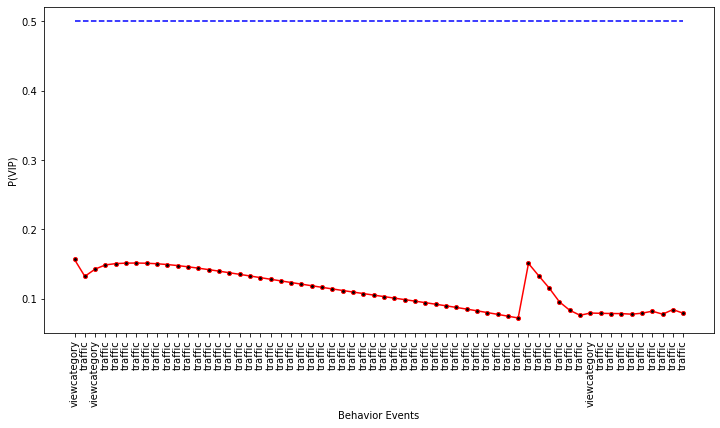

In [ ]:
output_ex(200)

## Tune LSTM

In [ ]:
def tune_LSTM(X_train, y_train, X_test, y_test, embedding_num, layers, neurons, lr, epochs, batch_size):
  model = Sequential()
  model.add(Embedding(input_dim=11, output_dim=embedding_num))
  model.add(LSTM(neurons, input_shape=(PADDING_LENGTH, embedding_num), return_sequences=True))

  if layers > 1:
    for i in range(1, layers):
      model.add(LSTM(neurons, return_sequences=True))

  model.add(Dense(1, activation='sigmoid'))

  decay_rate = lr / epochs
  opt = Adam(learning_rate=lr, decay=decay_rate)

  # Classification
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  callback = EarlyStopping(monitor='loss', patience=3)
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callback])

  prediction = model.predict(X_test)
  y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
  test_acc = accuracy_score(y_pred, y_test)
  test_f1 = f1_score(y_pred, y_test)
  test_AUC = roc_auc_score(y_pred, y_test)

  result = {
      'train_acc': history.history['accuracy'][-1],
      'val_acc': history.history['val_accuracy'][-1],
      'test_acc': test_acc,
      'test_f1': test_f1,
      'test_AUC': test_AUC
  }
  return result

In [ ]:
EPOCHS = 20
BATCH_SIZE = 512
LR = 0.01 

In [ ]:
embedding_nums = [6, 8 ,10 ,16]
layers = [1, 2, 3]
neurons = [8, 16, 32, 64]

### Embedding Neurons

In [ ]:
LAYERS = 1
NEURONS = 32

In [ ]:
model_list = []

for embedding_num in embedding_nums:
  print(embedding_num)
  model = tune_LSTM(X_train, y_train, X_test, y_test, embedding_num, LAYERS, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

6
Epoch 1/20
53/53 [==============================] - 8s 110ms/step - loss: 0.5820 - accuracy: 0.7014 - val_loss: 0.5530 - val_accuracy: 0.7176
Epoch 2/20
53/53 [==============================] - 5s 101ms/step - loss: 0.5442 - accuracy: 0.7179 - val_loss: 0.5436 - val_accuracy: 0.7187
Epoch 3/20
53/53 [==============================] - 5s 101ms/step - loss: 0.5352 - accuracy: 0.7223 - val_loss: 0.5344 - val_accuracy: 0.7252
Epoch 4/20
53/53 [==============================] - 5s 100ms/step - loss: 0.5300 - accuracy: 0.7263 - val_loss: 0.5323 - val_accuracy: 0.7314
Epoch 5/20
53/53 [==============================] - 5s 101ms/step - loss: 0.5284 - accuracy: 0.7276 - val_loss: 0.5299 - val_accuracy: 0.7331
Epoch 6/20
53/53 [==============================] - 5s 101ms/step - loss: 0.5270 - accuracy: 0.7283 - val_loss: 0.5291 - val_accuracy: 0.7329
Epoch 7/20
53/53 [==============================] - 5s 101ms/step - loss: 0.5262 - accuracy: 0.7294 - val_loss: 0.5281 - val_accuracy: 0.7314
Epoc

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

train_acc   val_acc  test_acc   test_f1  test_AUC
0   0.743809  0.745000  0.806658  0.775083  0.838969
1   0.743246  0.745772  0.798247  0.771010  0.821040
2   0.743740  0.744106  0.797891  0.765466  0.828410
3   0.745381  0.748013  0.807843  0.776891  0.839509

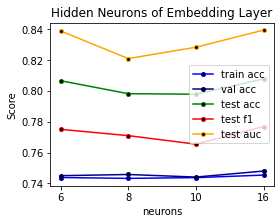

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(embedding_nums)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(embedding_nums)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(embedding_nums)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(embedding_nums)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(embedding_nums)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(embedding_nums)), embedding_nums)
plt.title('Hidden Neurons of Embedding Layer')
plt.xlabel('neurons')
plt.ylabel('Score')
plt.legend()
plt.show()

### LSTM Layers

In [ ]:
EMBEDDING = 16
NEURONS = 32

In [ ]:
model_list = []

for layer in layers:
  print(layer)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, layer, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

1
Epoch 1/20
53/53 [==============================] - 8s 123ms/step - loss: 0.5837 - accuracy: 0.7016 - val_loss: 0.5498 - val_accuracy: 0.7233
Epoch 2/20
53/53 [==============================] - 6s 113ms/step - loss: 0.5377 - accuracy: 0.7253 - val_loss: 0.5357 - val_accuracy: 0.7321
Epoch 3/20
53/53 [==============================] - 6s 113ms/step - loss: 0.5320 - accuracy: 0.7265 - val_loss: 0.5343 - val_accuracy: 0.7307
Epoch 4/20
53/53 [==============================] - 6s 114ms/step - loss: 0.5260 - accuracy: 0.7305 - val_loss: 0.5243 - val_accuracy: 0.7348
Epoch 5/20
53/53 [==============================] - 6s 113ms/step - loss: 0.5167 - accuracy: 0.7360 - val_loss: 0.5160 - val_accuracy: 0.7405
Epoch 6/20
53/53 [==============================] - 6s 113ms/step - loss: 0.5126 - accuracy: 0.7364 - val_loss: 0.5112 - val_accuracy: 0.7417
Epoch 7/20
53/53 [==============================] - 6s 115ms/step - loss: 0.5096 - accuracy: 0.7390 - val_loss: 0.5145 - val_accuracy: 0.7369
Epoc

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

train_acc   val_acc  test_acc   test_f1  test_AUC
0   0.743112  0.746530  0.803933  0.778061  0.826246
1   0.744644  0.746234  0.812345  0.786004  0.837730
2   0.742994  0.746187  0.801801  0.774983  0.824927

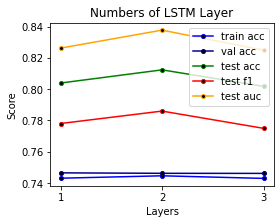

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(layers)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(layers)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(layers)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(layers)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(layers)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(layers)), layers)
plt.title('Numbers of LSTM Layer')
plt.xlabel('Layers')
plt.ylabel('Score')
plt.legend()
plt.show()

### Hidden Neurons of LSTM Layers

In [ ]:
EMBEDDING = 16
LAYERS = 2

In [ ]:
model_list = []

for neuron in neurons:
  print(neuron)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, LAYERS, neuron, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

8
Epoch 1/20
53/53 [==============================] - 9s 98ms/step - loss: 0.5986 - accuracy: 0.6899 - val_loss: 0.5661 - val_accuracy: 0.7220
Epoch 2/20
53/53 [==============================] - 4s 81ms/step - loss: 0.5458 - accuracy: 0.7208 - val_loss: 0.5305 - val_accuracy: 0.7247
Epoch 3/20
53/53 [==============================] - 4s 81ms/step - loss: 0.5301 - accuracy: 0.7219 - val_loss: 0.5284 - val_accuracy: 0.7272
Epoch 4/20
53/53 [==============================] - 4s 81ms/step - loss: 0.5203 - accuracy: 0.7279 - val_loss: 0.5187 - val_accuracy: 0.7329
Epoch 5/20
53/53 [==============================] - 4s 82ms/step - loss: 0.5140 - accuracy: 0.7334 - val_loss: 0.5137 - val_accuracy: 0.7399
Epoch 6/20
53/53 [==============================] - 4s 82ms/step - loss: 0.5111 - accuracy: 0.7371 - val_loss: 0.5137 - val_accuracy: 0.7389
Epoch 7/20
53/53 [==============================] - 4s 81ms/step - loss: 0.5096 - accuracy: 0.7379 - val_loss: 0.5120 - val_accuracy: 0.7415
Epoch 8/20


In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

train_acc   val_acc  test_acc   test_f1  test_AUC
0   0.741920  0.745760  0.796470  0.775718  0.810690
1   0.743813  0.745661  0.803104  0.774736  0.828921
2   0.744034  0.746629  0.806540  0.780422  0.829905
3   0.743426  0.741974  0.796588  0.763726  0.827348

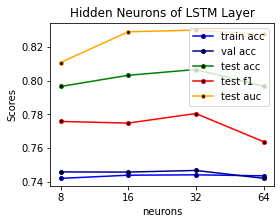

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(neurons)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(neurons)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(neurons)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(neurons)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(neurons)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(neurons)), neurons)
plt.title('Hidden Neurons of LSTM Layer')
plt.xlabel('neurons')
plt.ylabel('Scores')
plt.legend()
plt.show()

### 決定 learning rate

In [ ]:
EMBEDDING = 16
LAYERS = 2
NEURONS = 32

EPOCHS = 20
BATCH_SIZE = 512
LRs = [0.1, 0.01, 0.001]

In [ ]:
model_list = []

for LR in LRs:
  print(LR)
  model = tune_LSTM(X_train, y_train, X_test, y_test, EMBEDDING, LAYERS, NEURONS, LR, EPOCHS, BATCH_SIZE)
  model_list.append(model)

0.1
Epoch 1/20
53/53 [==============================] - 16s 233ms/step - loss: 0.5755 - accuracy: 0.6956 - val_loss: 0.5286 - val_accuracy: 0.7293
Epoch 2/20
53/53 [==============================] - 11s 215ms/step - loss: 0.5228 - accuracy: 0.7287 - val_loss: 0.5191 - val_accuracy: 0.7328
Epoch 3/20
53/53 [==============================] - 12s 218ms/step - loss: 0.5117 - accuracy: 0.7353 - val_loss: 0.5170 - val_accuracy: 0.7329
Epoch 4/20
53/53 [==============================] - 11s 216ms/step - loss: 0.5098 - accuracy: 0.7366 - val_loss: 0.5085 - val_accuracy: 0.7395
Epoch 5/20
53/53 [==============================] - 11s 217ms/step - loss: 0.5055 - accuracy: 0.7388 - val_loss: 0.5051 - val_accuracy: 0.7433
Epoch 6/20
53/53 [==============================] - 11s 216ms/step - loss: 0.5051 - accuracy: 0.7403 - val_loss: 0.5023 - val_accuracy: 0.7448
Epoch 7/20
53/53 [==============================] - 12s 219ms/step - loss: 0.5006 - accuracy: 0.7421 - val_loss: 0.5029 - val_accuracy: 0.

In [ ]:
result_df = pd.DataFrame(model_list)

In [ ]:
result_df

train_acc   val_acc  test_acc   test_f1  test_AUC
0   0.747574  0.748818  0.806421  0.781726  0.827658
1   0.744067  0.745456  0.806540  0.782005  0.827575
2   0.739350  0.742075  0.804644  0.776164  0.831104

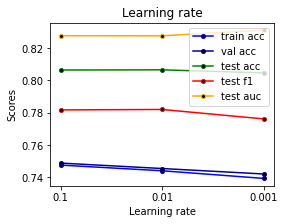

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(len(LRs)), result_df['train_acc'], color="blue", marker='o', markerfacecolor='black', markersize=4,  label='train acc')
plt.plot(range(len(LRs)), result_df['val_acc'], color="darkblue", marker='o', markerfacecolor='black', markersize=4, label='val acc')
plt.plot(range(len(LRs)), result_df['test_acc'], color="green", marker='o', markerfacecolor='black', markersize=4, label='test acc')
plt.plot(range(len(LRs)), result_df['test_f1'], color="red", marker='o', markerfacecolor='black', markersize=4, label='test f1')
plt.plot(range(len(LRs)), result_df['test_AUC'], color="orange", marker='o', markerfacecolor='black', markersize=4, label='test auc')
plt.xticks(range(len(LRs)), LRs)
plt.title('Learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Scores')
plt.legend()
plt.show()

In [ ]:
model_list[1]

{'test_AUC': 0.8275746309539551,
 'test_acc': 0.8065395095367848,
 'test_f1': 0.7820050727539714,
 'train_acc': 0.7440670728683472,
 'val_acc': 0.7454562783241272}

## 最佳 model 訓練

In [ ]:
model = Sequential()
  
model.add(Embedding(input_dim=11, output_dim=16))
model.add(LSTM(32, input_shape=(PADDING_LENGTH, 16), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

decay_rate = 0.01 / 20
opt = Adam(lr=0.01, decay=decay_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 16)          176       
                                                                 
 lstm_38 (LSTM)              (None, None, 32)          6272      
                                                                 
 lstm_39 (LSTM)              (None, None, 32)          8320      
                                                                 
 dense_27 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 14,801
Trainable params: 14,801
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)
EPOCHS = 20
BATCH_SIZE = 512
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[callback], verbose=1)

Epoch 1/20
53/53 [==============================] - 16s 232ms/step - loss: 0.5742 - accuracy: 0.7034 - val_loss: 0.5541 - val_accuracy: 0.7164
Epoch 2/20
53/53 [==============================] - 11s 212ms/step - loss: 0.5382 - accuracy: 0.7203 - val_loss: 0.5353 - val_accuracy: 0.7273
Epoch 3/20
53/53 [==============================] - 11s 213ms/step - loss: 0.5354 - accuracy: 0.7206 - val_loss: 0.5396 - val_accuracy: 0.7260
Epoch 4/20
53/53 [==============================] - 11s 215ms/step - loss: 0.5310 - accuracy: 0.7241 - val_loss: 0.5303 - val_accuracy: 0.7288
Epoch 5/20
53/53 [==============================] - 11s 213ms/step - loss: 0.5229 - accuracy: 0.7298 - val_loss: 0.5198 - val_accuracy: 0.7350
Epoch 6/20
53/53 [==============================] - 11s 216ms/step - loss: 0.5180 - accuracy: 0.7325 - val_loss: 0.5140 - val_accuracy: 0.7392
Epoch 7/20
53/53 [==============================] - 11s 213ms/step - loss: 0.5091 - accuracy: 0.7388 - val_loss: 0.5088 - val_accuracy: 0.7423

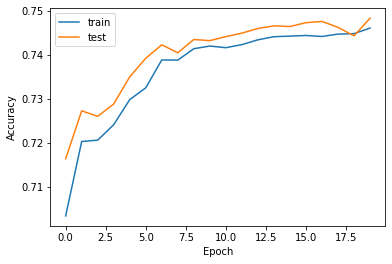

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
y_pred = (prediction[:, PADDING_LENGTH-1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1 score: ', f1_score(y_pred, y_test))
print('AUC score: ', roc_auc_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.807842672669115
F1 score:  0.7766455521894794
AUC score:  0.8399414223254351
Confusion matrix:


array([[3999,  153],
       [1469, 2820]])

In [ ]:
labels = ['Inactive', 'Active']

In [ ]:
Counter(y_test)

Counter({0: 4152, 1: 4289})

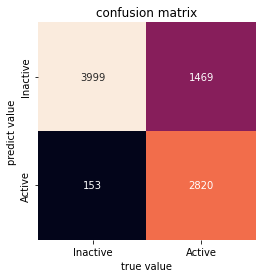

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred, y_test,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

    Inactive       0.96      0.73      0.83      5468
      Active       0.66      0.95      0.78      2973

    accuracy                           0.81      8441
   macro avg       0.81      0.84      0.80      8441
weighted avg       0.86      0.81      0.81      8441



In [ ]:
prediction_all = model.predict(np.array(X).reshape(len(X), PADDING_LENGTH, 1))

In [ ]:
y_pred_all = (prediction_all[:, -1] > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred_all, y))
print('F1 score: ', f1_score(y_pred_all, y))
print('AUC score: ', roc_auc_score(y_pred_all, y))
print('Confusion matrix:')
confusion_matrix(y_pred_all, y)

Accuracy of the model :  0.4266004217750295
F1 score:  0.3630925597522564
AUC score:  0.5006699534313801
Confusion matrix:


array([[22087,  7384],
       [40742, 13718]])

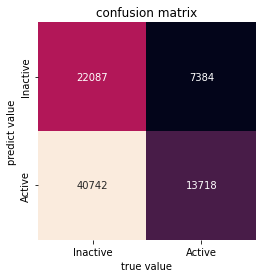

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

    Inactive       0.35      0.75      0.48     29471
      Active       0.65      0.25      0.36     54460

    accuracy                           0.43     83931
   macro avg       0.50      0.50      0.42     83931
weighted avg       0.55      0.43      0.40     83931



## 取得每層 layer output

In [ ]:
model.layers[0].get_weights()[0].shape

(11, 16)

In [ ]:
def get_layer_output(X, idx):
  get_output = K.function([model.layers[0].input], [model.layers[idx].output])
  return get_output([X])

In [ ]:
embedding_layer = get_layer_output(X_test, 0)
output_layer = get_layer_output(X_test, 3)
all_output_layer = get_layer_output(event_X_uds, 3)
# layer_output_3 = get_layer_output(X_test, 2)
# layer_output_5 = get_layer_output(X_test, 4)

In [ ]:
len(all_output_layer[0])

42204

In [ ]:
len(output_layer[0])

8441

In [ ]:
ot = pd.DataFrame(output_layer[0][:, PADDING_LENGTH-1], columns=['P'])
ot[ot['P']>0.5]

P
6     0.999379
7     0.999908
8     0.999618
11    0.588239
19    0.997122
...        ...
8424  0.999811
8429  0.999910
8433  0.999082
8434  0.999755
8439  0.991795

[2973 rows x 1 columns]

## 結果解釋

In [ ]:
bh_dict = ['None', 'add', 'checkout', 'purchase', 'register', 'search', 'traffic', 'viewactivity', 'viewcategory', 'viewmainpage', 'viewproduct']

In [ ]:
def get_output_df(idx, data, output_layer):
  bh_eg = list(data[idx].reshape(1,PADDING_LENGTH)[0])
  bh_eg = [i for i in bh_eg if i != 0] # 把 padding 的 event 拿掉
  output_eg = list(output_layer[0][idx].reshape(1,PADDING_LENGTH)[0])[-len(bh_eg):]
  bh_name_eg = [bh_dict[x] for x in bh_eg]

  df_eg = pd.DataFrame([idx] * len(bh_eg), columns=['Member'])
  df_eg['bh'] = bh_name_eg
  df_eg['Output'] = output_eg

  return df_eg

### 取得 all output of test data

In [ ]:
df_egs = []
for i in range(len(X_test)):
  df_eg = get_output_df(i, X_test, output_layer)
  df_egs.append(df_eg)

In [ ]:
test_output = pd.concat(df_egs)

In [ ]:
len(test_output['Member'].unique())

8441

In [ ]:
test_output.to_csv('Event Sequence + RF Outputs for test data.csv', index=False)

### 取得 all output of all undersampled data

In [ ]:
df_egs = []
for i in range(len(event_X_uds)):
  df_eg = get_output_df(i, event_X_uds, all_output_layer)
  df_egs.append(df_eg)

In [ ]:
all_output = pd.concat(df_egs)

In [ ]:
len(all_output['Member'].unique())

42204

In [ ]:
all_output.to_csv('Event Sequence + RF　Outputs.csv', index=False)

# RF model

## 取得 P(Active)

In [ ]:
all_data[event_cols].head()

e_1  e_2  e_3  e_4  e_5  e_6  e_7  e_8  e_9  e_10  ...  e_51  e_52  e_53  \
0    6    6    6    6    6    6    6    6    6    10  ...     9     9     8   
1    6    6   10    6    6    6    6    8    6     6  ...     9    10     1   
2    9    9    8   10    8   10    8   10    8    10  ...     8     9     9   
3    0    0    0    0    0    0    0    0    0     0  ...     0     0     0   
4    8    8    9    9    9    9    8    8    9     9  ...    10     8    10   

   e_54  e_55  e_56  e_57  e_58  e_59  e_60  
0     9     9     8     9     9     8     9  
1     8     9     9    10    10    10     9  
2     9     9     9    10    10    10    10  
3     0     0     0     8     8    10     8  
4     8    10     8    10     8     8     9  

[5 rows x 60 columns]

In [ ]:
all_event_X = np.array(all_data[event_cols]).reshape(len(all_data), PADDING_LENGTH, 1)
all_event_y = all_data['Active']

In [ ]:
active_preds = model.predict(all_event_X)

In [ ]:
active_preds_binary = (active_preds[:, -1] > 0.5)
print("Accuracy of the model : ", accuracy_score(active_preds_binary, all_event_y))
print('F1 score: ', f1_score(active_preds_binary, all_event_y))
print('AUC score: ', roc_auc_score(active_preds_binary, all_event_y))
print('Confusion matrix:')
confusion_matrix(active_preds_binary, all_event_y)

Accuracy of the model :  0.4266004217750295
F1 score:  0.3630925597522564
AUC score:  0.5006699534313801
Confusion matrix:


array([[22087,  7384],
       [40742, 13718]])

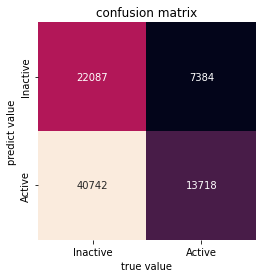

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=[0, 1],target_names=labels))

report:
               precision    recall  f1-score   support

    Inactive       0.35      0.75      0.48     29471
      Active       0.65      0.25      0.36     54460

    accuracy                           0.43     83931
   macro avg       0.50      0.50      0.42     83931
weighted avg       0.55      0.43      0.40     83931



In [ ]:
all_data['Active_Probability'] = active_preds[:, -1]

## Build Model

In [ ]:
# all X columns
X_cols = ['Lifespan_days', 'CAI', 'Monetary', 'Recency', 'Frequency', 'ActiveDays', 'PromotionUsedRate', 'CompleteOrders', 'ReturnRate', 'Active_Probability']

In [ ]:
X = all_data[X_cols]
y = all_data['VIP'].astype(int)

In [ ]:
pd.concat([X,y], axis=1).to_csv('Features of Event based + RF.csv', index=False)

### Step 1: Undersampling major class Experiment 

In [ ]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 72733, 1: 11198})


In [ ]:
print('Total: ', len(all_data))
print('Not VIP %:', counter[0]/len(all_data))
print('VIP %:', counter[1]/len(all_data))

Total:  83931
Not VIP %: 0.8665808819149063
VIP %: 0.1334191180850937


In [ ]:
class ActivePrediction():
  def __init__(self, X, y, active_weight, X_cols):
    self.X = X
    self.y = y
    self.active_weight = active_weight
    self.X_cols = X_cols

    self.reset()

  def reset(self):
    self.data_res = []
    self.X_binary = []
    self.y_binary = []

    self.cv_score_accuracy = []
    self.cv_score_roc = []

    self.train_accuracy = 0
    self.test_accuracy = 0
    self.test_F1 = 0
    self.test_auc = 0

    self.classification_report = []

    self.y_test = []
    self.y_preds = []

  def undersampling(self):
    print('------------------- Start to undersampling-------------------------')
    counter = Counter(y)
    inactive_num = int(counter[1]*(1-self.active_weight)/self.active_weight)
    nm = NearMiss(sampling_strategy={0: inactive_num}, version=1)
    X_res, y_res = nm.fit_resample(self.X, self.y)

    # summarize the new class distribution
    counter = Counter(y_res)
    print('undersampling:', counter)
    print('------------------- Finished to undersampling-------------------------')
    return pd.concat([X_res, y_res], axis=1)
    

  def cross_val(self, score, X_train, y_train):
    rfc_cv_score = cross_val_score(self.model, X_train, y_train, cv=5, scoring=score)
    return {'scores': rfc_cv_score, 'Mean score': rfc_cv_score.mean()}

  def train_RF_model(self, X_train, X_test, y_train, y_test):
    self.model = RandomForestClassifier(max_depth=5,n_estimators=200)
    self.model.fit(X_train, y_train)
    self.y_pred = self.model.predict(X_test)
    print('------------------- Start to CV-------------------------')
    self.cv_score_accuracy = self.cross_val('accuracy', X_train, y_train)
    self.cv_score_roc = self.cross_val('roc_auc_ovr', X_train, y_train)
    print('------------------- Finished to CV-------------------------')

    print("Accuracy score on train data:", self.model.score(X_train, y_train))
    print("Accuracy score on test data:", self.model.score(X_test, y_test))
    
    self.train_accuracy = self.model.score(X_train, y_train)
    self.test_accuracy = self.model.score(X_test, y_test)

    self.test_F1 = f1_score(y_test, self.y_pred)
    self.test_auc = roc_auc_score(y_test, self.y_pred)
    print('F1 score on test data:', self.test_F1)
    print('AUC score on test data:', self.test_auc)
 
    labels = [0, 1]
    label_names = ['Not VIP', 'VIP']
    self.classification_report = classification_report(y_test, self.y_pred,labels=labels,target_names=label_names)

  def build_model(self):
    if self.active_weight == 0:
      self.data_res = pd.concat([self.X, self.y], axis=1)
      X_binary = self.X
      y_binary = self.y
    else:
      self.data_res = self.undersampling()
      X_binary = self.data_res[X_cols]
      y_binary = self.data_res['VIP'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=123)

    self.train_RF_model(X_train, X_test, y_train, y_test)
    self.y_test = y_test

In [ ]:
active_weights = [0.3, 0.4, 0.5]
models = []

for w in active_weights:
  print('Active_weight:', w)
  model = ActivePrediction(X, y, w, X_cols)
  model.build_model()

  models.append(model)

Active_weight: 0.3
------------------- Start to undersampling-------------------------
undersampling: Counter({0: 26128, 1: 11198})
------------------- Finished to undersampling-------------------------
------------------- Start to CV-------------------------
------------------- Finished to CV-------------------------
Accuracy score on train data: 0.9082049564634963
Accuracy score on test data: 0.9032949370479507
F1 score on test data: 0.8185929648241206
AUC score on test data: 0.8499043323420497
Active_weight: 0.4
------------------- Start to undersampling-------------------------
undersampling: Counter({0: 16797, 1: 11198})
------------------- Finished to undersampling-------------------------
------------------- Start to CV-------------------------
------------------- Finished to CV-------------------------
Accuracy score on train data: 0.9133773888194321
Accuracy score on test data: 0.9133773888194321
F1 score on test data: 0.8829915560916767
AUC score on test data: 0.8968268999937

In [ ]:
pd.DataFrame([models[0].cv_score_accuracy, models[1].cv_score_accuracy, models[2].cv_score_accuracy])

scores  Mean score
0  [0.9063965170797053, 0.9109176155391828, 0.902...    0.905928
1  [0.9102678571428572, 0.9158294262112079, 0.913...    0.911011
2  [0.9202008928571429, 0.9207368127267653, 0.933...    0.919681

In [ ]:
pd.DataFrame([models[0].cv_score_roc, models[1].cv_score_roc, models[2].cv_score_roc])

scores  Mean score
0  [0.9202542529511504, 0.9203583836240956, 0.910...    0.916430
1  [0.9445028134483016, 0.9467496468882521, 0.939...    0.942537
2  [0.9567394633068249, 0.9622053966473484, 0.966...    0.958098

In [ ]:
labels = [0, 1]
label_names = ['Not VIP', 'VIP']

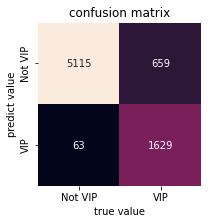

In [ ]:
matric = confusion_matrix(models[0].y_pred, models[0].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

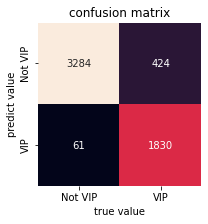

In [ ]:
matric = confusion_matrix(models[1].y_pred, models[1].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

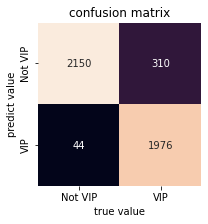

In [ ]:
matric = confusion_matrix(models[2].y_pred, models[2].y_test)
plt.figure(figsize=(3,3))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",models[0].classification_report)

report:
               precision    recall  f1-score   support

     Not VIP       0.89      0.99      0.93      5178
         VIP       0.96      0.71      0.82      2288

    accuracy                           0.90      7466
   macro avg       0.92      0.85      0.88      7466
weighted avg       0.91      0.90      0.90      7466



In [ ]:
print("report:\n",models[1].classification_report)

report:
               precision    recall  f1-score   support

     Not VIP       0.89      0.98      0.93      3345
         VIP       0.97      0.81      0.88      2254

    accuracy                           0.91      5599
   macro avg       0.93      0.90      0.91      5599
weighted avg       0.92      0.91      0.91      5599



In [ ]:
print("report:\n",models[2].classification_report)

report:
               precision    recall  f1-score   support

     Not VIP       0.87      0.98      0.92      2194
         VIP       0.98      0.86      0.92      2286

    accuracy                           0.92      4480
   macro avg       0.93      0.92      0.92      4480
weighted avg       0.93      0.92      0.92      4480



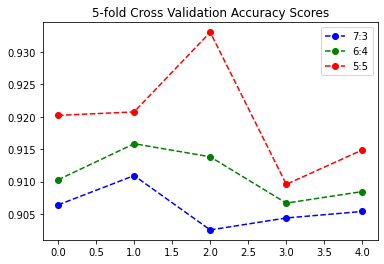

In [ ]:
plt.plot(models[0].cv_score_accuracy['scores'], linestyle='--', marker='o', color='b', label='7:3')
plt.plot(models[1].cv_score_accuracy['scores'], linestyle='--', marker='o', color='g', label='6:4')
plt.plot(models[2].cv_score_accuracy['scores'], linestyle='--', marker='o', color='r', label='5:5')
plt.title('5-fold Cross Validation Accuracy Scores')
plt.legend()

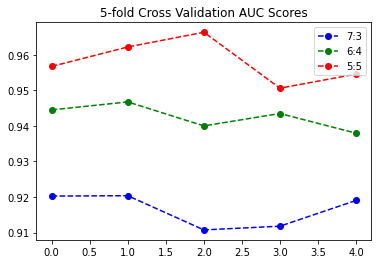

In [ ]:
plt.plot(models[0].cv_score_roc['scores'], linestyle='--', marker='o', color='b', label='7:3')
plt.plot(models[1].cv_score_roc['scores'], linestyle='--', marker='o', color='g', label='6:4')
plt.plot(models[2].cv_score_roc['scores'], linestyle='--', marker='o', color='r', label='5:5')
plt.title('5-fold Cross Validation AUC Scores')
plt.legend()

### Train Binary Model

In [ ]:
counter = Counter(y)

In [ ]:
active_weight = 0.5
inactive_num = int(counter[1]*(1-active_weight)/active_weight)
nm = NearMiss(sampling_strategy={0: inactive_num}, version=1)
X_res, y_res = nm.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y_res)
print('undersampling:', counter)

undersampling: Counter({0: 11198, 1: 11198})


In [ ]:
data_res = pd.concat([X_res, y_res], axis=1)

In [ ]:
data_res.to_csv('Event Sequence + Random Forest UnderSampled Data(model 2).csv', index=False)

### 訓練 model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=123)

In [ ]:
data_res['Train/Test'] = ['Train'] * len(data_res)
data_res.loc[X_test.index, 'Train/Test'] = 'Test'

In [ ]:
data_res.to_csv('Train Test Data(model 2).csv', index=False)

In [ ]:
Counter(y_train)

Counter({0: 9004, 1: 8912})

In [ ]:
Counter(y_test)

Counter({0: 2194, 1: 2286})

### Hyperparameter Tuning

In [ ]:
# Determine optimal parameters:
# Declare a baseline classifier:
forest = RandomForestClassifier()

# Create the grid parameter:
grid_rf = {
    'n_estimators': [100, 120, 150, 200],
    'criterion': ['entropy', 'gini'], 
    'max_depth': range(2,6),
    'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,11),
    # 'n_estimators': [100],
    # 'criterion': ['entropy'],
    # 'max_depth': [5],
    # 'max_features': [4],
    # 'min_samples_split': [4],
    # 'min_samples_leaf': [4]
}

# Create the grid:
gs_rf = GridSearchCV(forest, grid_rf, cv=5, n_jobs=-1, verbose=1)

# Fit using grid search:
gs_rf.fit(X_train, y_train)

# Print best accuracy and best parameters:
print('Best accuracy: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.921

Best params:
 {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}


In [ ]:
rf_model = RandomForestClassifier(max_depth=5,n_estimators=150,criterion='gini',max_features='auto',min_samples_split=2,min_samples_leaf=4)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
print("=== All ACCURACY Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean ACCURACY Score ===")
print("Mean ACCURACY Score - Random Forest: ", rfc_cv_score.mean())

=== All ACCURACY Scores ===
[0.9171317  0.91962043 0.92966788 0.91320123 0.91822495]


=== Mean ACCURACY Score ===
Mean ACCURACY Score - Random Forest:  0.9195692362993899


Text(0.5, 1.0, '5-fold Cross Validation Accuracy Scores')

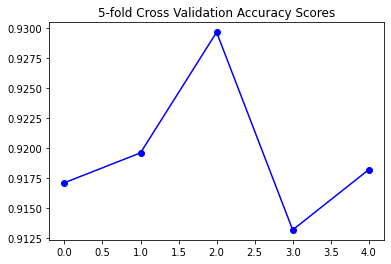

In [ ]:
plt.plot(rfc_cv_score, marker='o', color='b')
plt.title('5-fold Cross Validation Accuracy Scores')

In [ ]:
rfc_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc_ovr')

In [ ]:
print("=== All ROC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean ROC Score ===")
print("Mean ROC Score - Random Forest: ", rfc_cv_score.mean())

=== All ROC Scores ===
[0.95693659 0.96266685 0.96622995 0.95124388 0.95436022]


=== Mean ROC Score ===
Mean ROC Score - Random Forest:  0.958287497667999


Text(0.5, 1.0, '5-fold Cross Validation AUC Scores')

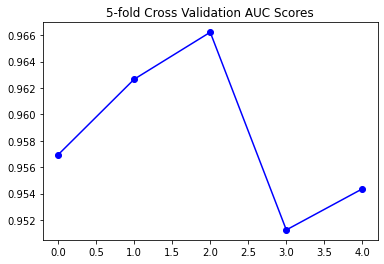

In [ ]:
plt.plot(rfc_cv_score, marker='o', color='b')
plt.title('5-fold Cross Validation AUC Scores')

In [ ]:
print("Accuracy score on train data:", rf_model.score(X_train, y_train))
print("Accuracy score on test data:", rf_model.score(X_test, y_test))
print("F1 score on test data:", f1_score(y_test, y_pred))
print("AUC score on test data:", roc_auc_score(y_test, y_pred))

Accuracy score on train data: 0.9233087742799732
Accuracy score on test data: 0.9216517857142857
F1 score on test data: 0.9188063844552394
AUC score on test data: 0.9227605949894367


In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

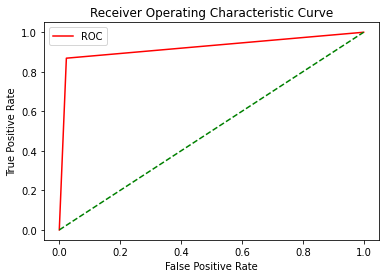

In [ ]:
fper, tper, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fper, tper)

In [ ]:
labels = [0, 1]
label_names = ['Not VIP', 'VIP']

In [ ]:
len(y_test)

4480

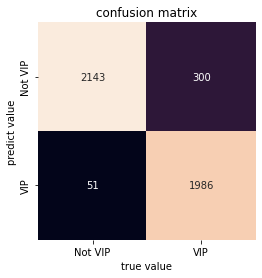

In [ ]:
matric = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_test, y_pred,labels=labels,target_names=label_names))

report:
               precision    recall  f1-score   support

     Not VIP       0.88      0.98      0.92      2194
         VIP       0.97      0.87      0.92      2286

    accuracy                           0.92      4480
   macro avg       0.93      0.92      0.92      4480
weighted avg       0.93      0.92      0.92      4480



In [ ]:
importance = list(rf_model.feature_importances_)
rf_FS = pd.DataFrame({'Columns': list(X_res.columns), 'Importance': importance}).sort_values(by=["Importance"], ascending=False)
rf_FS

Columns  Importance
7      CompleteOrders    0.322699
5          ActiveDays    0.197129
4           Frequency    0.129926
2            Monetary    0.100825
3             Recency    0.083351
0       Lifespan_days    0.081309
1                 CAI    0.069061
8          ReturnRate    0.008376
6   PromotionUsedRate    0.006754
9  Active_Probability    0.000570

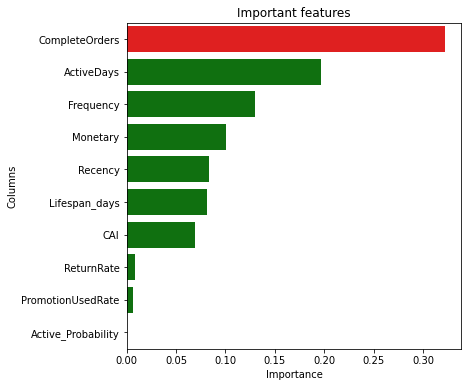

In [ ]:
values = rf_FS.Importance    
idx = rf_FS.Columns
plt.figure(figsize=(6,6))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features')
plt.show()

In [ ]:
fn=X_res.columns
cn=label_names
# plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (45,8), dpi=800)
tree.plot_tree(rf_model.estimators_[0], feature_names = fn, class_names=cn, filled = True, rounded=True, fontsize=7, impurity=False);
# fig.savefig('rf_individualtree.png')

In [ ]:
y_pred_all = rf_model.predict(X)

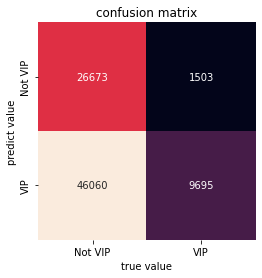

In [ ]:
matric = confusion_matrix(y_pred_all, y)
plt.figure(figsize=(4,4))
sns.heatmap(matric,square=True,annot=True,cbar=False,fmt='d',xticklabels=label_names, yticklabels=label_names)
plt.ylabel("predict value")
plt.xlabel("true value")
plt.title("confusion matrix")
plt.show()

In [ ]:
print("report:\n",classification_report(y_pred_all, y,labels=labels,target_names=label_names))

report:
               precision    recall  f1-score   support

     Not VIP       0.37      0.95      0.53     28176
         VIP       0.87      0.17      0.29     55755

    accuracy                           0.43     83931
   macro avg       0.62      0.56      0.41     83931
weighted avg       0.70      0.43      0.37     83931

